In [1]:
import logging
import pandas as pd
import numpy as np
import gensim
import nltk
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
from sklearn.linear_model  import LogisticRegression
from gensim.models import KeyedVectors
from nltk.corpus import stopwords
import re
from bs4 import BeautifulSoup

In [2]:
wv = KeyedVectors.load_word2vec_format("GoogleNews-vectors-negative300.bin.gz", binary=True)
wv.init_sims(replace=True)

C:\Users\einst\AppData\Local\Temp\ipykernel_39672\1116314587.py:2: DeprecationWarning: Call to deprecated `init_sims` (Use fill_norms() instead. See https://github.com/RaRe-Technologies/gensim/wiki/Migrating-from-Gensim-3.x-to-4).
  wv.init_sims(replace=True)


In [3]:
from itertools import islice
list(islice(wv.key_to_index, 13030, 13050))

['Memorial_Hospital',
 'Seniors',
 'memorandum',
 'elephant',
 'Trump',
 'Census',
 'pilgrims',
 'De',
 'Dogs',
 '###-####_ext',
 'chaotic',
 'forgive',
 'scholar',
 'Lottery',
 'decreasing',
 'Supervisor',
 'fundamentally',
 'Fitness',
 'abundance',
 'Hold']

In [4]:
raw_numpy = pd.read_csv("numpy.csv")
raw_pandas = pd.read_csv("pandas.csv")
raw_csharp = pd.read_csv("csharp.csv")
raw_matlab = pd.read_csv("matlab.csv")
raw_matplotlib = pd.read_csv("matplotlib.csv")
raw_mongodb = pd.read_csv("mongodb.csv")
raw_tensorflow = pd.read_csv("tensorflow.csv")
raw_typescript = pd.read_csv("typescript.csv")

In [5]:
print(raw_numpy.shape)
print(raw_pandas.shape)
print(raw_csharp.shape)
print(raw_matlab.shape)
print(raw_matplotlib.shape)
print(raw_mongodb.shape)
print(raw_tensorflow.shape)
print(raw_typescript.shape)

(45005, 1)
(47904, 1)
(45664, 1)
(45921, 1)
(43507, 1)
(44070, 1)
(41255, 1)
(47392, 1)


In [6]:
raw_numpy["Tag"]="numpy"
raw_pandas["Tag"]="pandas"
raw_csharp["Tag"]="csharp"
raw_matlab["Tag"]="matlab"
raw_matplotlib["Tag"]="matplotlib"
raw_mongodb["Tag"]="mongodb"
raw_tensorflow["Tag"]="tensorflow"
raw_typescript["Tag"]="typescript"

In [7]:
print(raw_numpy.shape)
print(raw_pandas.shape)
print(raw_csharp.shape)
print(raw_matlab.shape)
print(raw_matplotlib.shape)
print(raw_mongodb.shape)
print(raw_tensorflow.shape)
print(raw_typescript.shape)

(45005, 2)
(47904, 2)
(45664, 2)
(45921, 2)
(43507, 2)
(44070, 2)
(41255, 2)
(47392, 2)


In [8]:
df = pd.concat([raw_numpy, raw_pandas, raw_csharp, raw_matlab, raw_matplotlib, raw_mongodb, raw_tensorflow, raw_typescript], axis=0)
df = df.reset_index(drop=True)
#df = df[pd.notnull(df['Tag'])]
df.shape

(360718, 2)

In [9]:
print(df['Questions'].apply(lambda x: len(x.split(' '))).sum())

3636886


In [10]:
def print_plot(index):
    example = df[df.index == index][['Questions', 'Tag']].values[0]
    if len(example) > 0:
        print(example[0])
        print('Tag:', example[1])
print_plot(10)
print_plot(300000)

Sum rows of 2D array with elements of 1D array
Tag: numpy
Running automatic annotation in cvat with tensorflow results in status code 400 "No labels found for tf annotation"
Tag: tensorflow


In [11]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = BeautifulSoup(text, "lxml").text # HTML decoding
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text
    text = BAD_SYMBOLS_RE.sub('', text) # delete symbols which are in BAD_SYMBOLS_RE from text
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # delete stopwors from text
    return text
    
df['Questions'] = df['Questions'].apply(clean_text)
print_plot(10)
print_plot(300000)

C:\Users\einst\AppData\Roaming\Python\Python311\site-packages\bs4\__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(


sum rows 2d array elements 1d array
Tag: numpy
running automatic annotation cvat tensorflow results status code 400 labels found tf annotation
Tag: tensorflow


<Axes: >

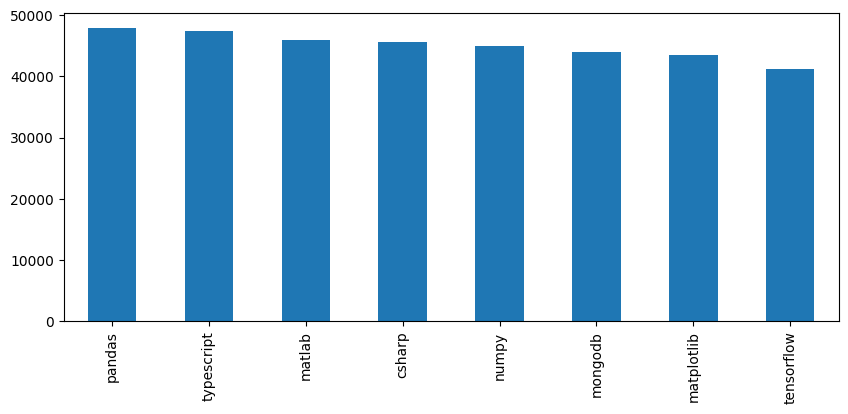

In [12]:
my_tags=["numpy","pandas","csharp","matlab","matplotlib","mongodb","tensorflow","typescript"]

plt.figure(figsize=(10,4))
df.Tag.value_counts().plot(kind='bar')

In [13]:
def word_averaging(wv, words):
    all_words, mean = set(), []
    
    for word in words:
        if isinstance(word, np.ndarray):
            mean.append(word)
        elif word in wv.key_to_index:
            mean.append(wv.get_vector(word, norm=True))
            all_words.add(wv.key_to_index[word])

    if not mean:
        logging.warning("cannot compute similarity with no input %s", words)
        # FIXME: remove these examples in pre-processing
        return np.zeros(wv.vector_size,)

    mean = gensim.matutils.unitvec(np.array(mean).mean(axis=0)).astype(np.float32)
    return mean

def  word_averaging_list(wv, text_list):
    return np.vstack([word_averaging(wv, post) for post in text_list ])

In [14]:
def w2v_tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text, language='english'):
        for word in nltk.word_tokenize(sent, language='english'):
            if len(word) < 2:
                continue
            tokens.append(word)
    return tokens
    
train, test = train_test_split(df, test_size=0.3, random_state = 42)

test_tokenized = test.apply(lambda r: w2v_tokenize_text(r['Questions']), axis=1).values
train_tokenized = train.apply(lambda r: w2v_tokenize_text(r['Questions']), axis=1).values

In [15]:
X_train_word_average = word_averaging_list(wv,train_tokenized)
X_test_word_average = word_averaging_list(wv,test_tokenized)

In [16]:
logreg = LogisticRegression(n_jobs=1, C=1e5)
logreg = logreg.fit(X_train_word_average, train['Tag'])
y_pred = logreg.predict(X_test_word_average)
print('accuracy %s' % accuracy_score(y_pred, test.Tag))
print(classification_report(test.Tag, y_pred,target_names=my_tags))

C:\Users\einst\AppData\Roaming\Python\Python311\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


accuracy 0.6317365269461078
              precision    recall  f1-score   support

       numpy       0.51      0.57      0.54     13615
      pandas       0.78      0.67      0.72     13827
      csharp       0.68      0.67      0.68     13100
      matlab       0.65      0.65      0.65     13252
  matplotlib       0.51      0.45      0.48     13598
     mongodb       0.67      0.70      0.68     14267
  tensorflow       0.59      0.67      0.63     12334
  typescript       0.68      0.68      0.68     14223

    accuracy                           0.63    108216
   macro avg       0.63      0.63      0.63    108216
weighted avg       0.64      0.63      0.63    108216

